# Control moment gyroscope project

Import modules and configure the notebook.

# Linearization

In [1]:
# This module is part of the python standard library
import time
import sympy as sym
# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_cmg)

<module 'ae353_cmg' from 'C:\\Users\\Gover\\documents\\projects\\ae353\\code\\ae353_cmg.py'>

In [2]:
from sympy.physics import mechanics
mechanics.init_vprinting()

Create an instance of the robot simulator. This will open a window in which you should see the platform with a single-gimbal control moment gyroscope.

There are three optional parameters:

* `damping` is the coefficient of viscouse friction at each joint (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.001`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [3]:
robot = ae353_cmg.RobotSimulator(damping=0., dt=0.001, display=True)

Define and create an instance of the robot controller. By default, it chooses to apply zero torque both to the gimbal and to the rotor. Modify the `run` function - or anything else in the class definition - to make the controller behave differently.

In [4]:
q1_des = 2.0; #choose a desired platform angle in radians

Let the state variable x = `[[q1-q1_e],[q2-q2_e],[v1-v1_e],[v2-v2_e],[v3-v3_e]] `.We know that in general, the state space model is expressed as` x_dot = Ax + Bu`, where u is the input variable and x is the state variable as we have defined above. As suggested by the project guidelines, we can restrict our attention to the gimbal and the platform (assuming `tau_3 `and` v_3 `are constant).

In [5]:
#linearizing the equations of motion as given in "DeriveEOM" :

q1, q2,v1,v2,v3,tau2,tau3 = mechanics.dynamicsymbols('q1, q2,v1,v2,v3,tau2,tau3')
q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e = mechanics.dynamicsymbols('q1_e, q_2e,v1_e,v2_e,\
                                                                  v3_e,tau2_e,tau3_e')
t = sym.symbols('t')



x = sym.Matrix([[q1-q1_e],[q2-q2_e],[v1-v1_e],[v2-v2_e]]) #state variable is defined
u = sym.Matrix([[tau2-tau2_e],[tau3-tau3_e]])

q1_dot = q1.diff(t)
q2_dot = q2.diff(t)

v1_dot = -(5*(200*tau3*sym.sin(q2)+sym.sin(2*q2)*v1*v2+2*sym.cos(q2)*v2*v3))/(10*sym.sin(q2)**2-511)
v2_dot = 10*(100*tau2-sym.cos(q2)*v1*v3)/11
v3_dot =0  #initial spin rate is a constant, thus its derivative is 0
x_dot = sym.Matrix([[q1_dot],[q2_dot],[v1_dot],[v2_dot]])

sym.nsimplify(x_dot) # time derivative of state variable 


⎡                          q₁̇                           ⎤
⎢                                                       ⎥
⎢                          q₂̇                           ⎥
⎢                                                       ⎥
⎢-1000⋅τ₃⋅sin(q₂) - 5⋅v₁⋅v₂⋅sin(2⋅q₂) - 10⋅v₂⋅v₃⋅cos(q₂)⎥
⎢───────────────────────────────────────────────────────⎥
⎢                         2                             ⎥
⎢                   10⋅sin (q₂) - 511                   ⎥
⎢                                                       ⎥
⎢              1000⋅τ₂   10⋅v₁⋅v₃⋅cos(q₂)               ⎥
⎢              ─────── - ────────────────               ⎥
⎣                 11            11                      ⎦

In [6]:
x #state variable symbolic form

⎡q₁ - q₁ ₑ⎤
⎢         ⎥
⎢q₂ - q₂ₑ ⎥
⎢         ⎥
⎢v₁ - v₁ ₑ⎥
⎢         ⎥
⎣v₂ - v₂ ₑ⎦

In [7]:
u #input variable symbolic form

⎡τ₂ - τ₂ ₑ⎤
⎢         ⎥
⎣τ₃ - τ₃ ₑ⎦

In [8]:
#now assume an equilibrium angle for the platform 
q1_e = 2.0# equilibrium value(desired) chosen for q1
q2_e = np.pi #equilibrium value chosen for q2
v1_e= 0 
v2_e= 0
v3_e = 0 #rad/s
tau2_e =0 # Nm
tau3_e = 1   # Nm
#the above equilibrium values are chosen such that x_dot goes to 0

# To find matrix A and B for the state-space model, we first assume v3 and tau3 are both constant
# That means angular velocity of the rotor and torque applied to the rotor are constant values, so
# the time derivatives of those two terms are equal to zero

x_dot_equilibrium = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3),x_dot)
np.set_printoptions(suppress=True)

A_num = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3), x_dot.jacobian([q1,q2,v1,v2]))
A = A_num(q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e)

B_num = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3),x_dot.jacobian([tau2,tau3]))
B = B_num(q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e)

A = sym.Matrix(A,rational=True)
B = sym.Matrix(B,rational=True)



 # this is our state-space model at equilibrium conditions


In [9]:
A #matrix to be multiplied by state variable x

⎡0.0         0.0         0.0  0.0⎤
⎢                                ⎥
⎢0.0         0.0         0.0  0.0⎥
⎢                                ⎥
⎢0.0  -1.95694716242661  0.0  0.0⎥
⎢                                ⎥
⎣0.0         0.0         0.0  0.0⎦

In [10]:
B #matrix to be multiplied by input variable u

⎡      0.0                 0.0         ⎤
⎢                                      ⎥
⎢      0.0                 0.0         ⎥
⎢                                      ⎥
⎢      0.0         2.39656907856625e-16⎥
⎢                                      ⎥
⎣90.9090909090909          0.0         ⎦

In [11]:
A@x+B@u #expanded state-space form (x_dot = Ax+Bu)

⎡                                                0                            
⎢                                                                             
⎢                                                0                            
⎢                                                                             
⎢-1.95694716242661⋅q₂ + 1.95694716242661⋅q₂ₑ + 2.39656907856625e-16⋅τ₃ - 2.396
⎢                                                                             
⎣                           90.9090909090909⋅τ₂ - 90.9090909090909⋅τ₂ ₑ       

                    ⎤
                    ⎥
                    ⎥
                    ⎥
56907856625e-16⋅τ₃ ₑ⎥
                    ⎥
                    ⎦

Thus, our state-space model is in the form of a four by one matrix.

It is known that state-space model can also be expressed as `x_dot = (A-BK)x`, where `u = -Kx`
We can denote `A-BK` as` F`. However, to make our state-space model acheive asymptotical stability, the eigen values of`F` must all have negative real parts. Whether or not all real parts of `F` are negative depends on the choice of matrix `K`.

In [13]:
#We can try to randomly designate some values for a gain matrix K
B = np.array(B)
A = np.array(A)
K = np.array([[11,-15,67,45],[-25,10,9,12]]) # a random 2 by 4 matrix that can be multiplied by B
B = B.astype(float)
A = A.astype(float)
F = A-B@K

np.set_printoptions(suppress=True,precision=3)

#We know to achieve asymptotic stability, all eigen values of F must have negative real parts

s,V = linalg.eig(F)
S = np.diag(s)        #eigen values on the diagonal
(S.real<0).all()      # check if all real parts are negative   

#It turns out that our non-systemtic approach is inefficient and does not yield a correct result


False

In [14]:
#now let's use a while loop and test if randomly-generatred entries in matrix K satisfies the 
#negative-real part condition
i=0

while i < 10:

    K_new = np.array([[np.random.uniform(-100,100),np.random.uniform(-100,100),np.random.uniform(-100,100),\
                      np.random.uniform(-100,100)],[np.random.uniform(-100,100),np.random.uniform(-100,100),\
                                                np.random.uniform(-100,100),np.random.uniform(-100,100)]])
    #above is a two by one matrix with its entries generated uniformly and randomly
    F_new = A - B @ K_new
    s_new = linalg.eigvals(F_new)
    
    if (s_new.real <= 0).all()==True: # eigen values with all real parts <0 cannot be found
                                      #Details to be discussed BELOW
        print(K_new)
        i+=1
        
        break
        
    




[[-27.802  39.366 -16.148  67.732]
 [ 77.424 -98.311 -73.935  93.05 ]]


In [15]:
#let's test whether or not the above gain matrix K makes (A-B@K) satisfy the 
#negative real part condition
#this matrix will change everytime the cell above is run
K_new = np.array([[ -9.954, -14.25,  -22.184 , 68.193],\
                 [-58.311 ,-93.884 , 20.269 ,-19.834]])
F_new = A-B@K_new

s = linalg.eigvals(F_new)
S = np.diag(s)
(S.real<=0).all() 


True

In [16]:
S

array([[    0.   +0.j,     0.   +0.j,     0.   +0.j,     0.   +0.j],
       [    0.   +0.j, -6199.364+0.j,     0.   +0.j,     0.   +0.j],
       [    0.   +0.j,     0.   +0.j,     0.   +0.j,     0.   +0.j],
       [    0.   +0.j,     0.   +0.j,     0.   +0.j,     0.   +0.j]])

After running the while loop above, we successfully capture a gain matrix `k` such that the controller will satisfy the negative real part condition.

In [17]:
F_new #F = A-B@K

array([[    0.   ,     0.   ,     0.   ,     0.   ],
       [    0.   ,     0.   ,     0.   ,     0.   ],
       [    0.   ,    -1.957,    -0.   ,     0.   ],
       [  904.909,  1295.455,  2016.727, -6199.364]])

In [18]:
t = sym.symbols('t')
q1_0,q2_0,v1_0,v2_0,v3_0=sym.symbols('q1_0,q2_0,v1_0,v2_0,v3_0') #initial values associated 
                                                                 #with each variable

 #suppress scientific notation & restrict precision

# Solution 
q1_0 = 0 #0 angle of platform initially
q2_0 = 0 # 0 angle of gimbal initially
v1_0 = 0 #0 angular velocity of platform initially
v3_0 = (100*2*np.pi)/60 #rad/s initial angular velocity of rotor
v2_0 = 0 #0 angular velocity of gimbal initially

q1_e = 2.0# equilibrium value(desired) chosen for q1
q2_e = np.pi #equilibrium value chosen for q2
v1_e= 0 
v2_e= 0
v3_e = 0 #rad/s
tau2_e =0 # Nm
tau3_e = 1   # Nm

x0 = sym.Matrix([[q1_0-q1_e],[q2_0-q2_e],[v1_0-v1_e],[v2_0-v2_e]])
F_new = sym.Matrix(F_new)
# Solution (symbolic) 
x = sym.exp(F_new * t) @ x0
np.set_printoptions(suppress=True,precision=2)
sym.simplify(x).expand()  #  x = exp(F*t)@x0

⎡                        -1.21460183660255                        ⎤
⎢                                                                 ⎥
⎢                        -3.14159265358979                        ⎥
⎢                                                                 ⎥
⎢                                  -6199.36363636364⋅t            ⎥
⎢           -0.000991703534356463⋅ℯ                               ⎥
⎢                                                                 ⎥
⎢                                              -6199.36363636364⋅t⎥
⎣-1.29338765695307e+15 + 1.29338765695307e+15⋅ℯ                   ⎦

After using a brute force method (while loop above), I realize that a gain matrix `K` that makes all real parts of eigen values of `F` negative does not exist. After printing out eigen values( cell deleted for asthetics reason) of many different `F` generated by the while loop, we notice that all of them contain at least a zero as the real part, which is not negative. Thus, I change the "negative-real-part" condition to "negative-or-zero" condition for now.

In [22]:
class RobotController:
    def __init__(self, dt=0.01, K=np.array([[ -9.954,-14.25,-22.184,68.193],\
                         [-58.311,-93.884,20.269,-19.834]])):
        self.dt = dt
        
        # Choose equilibrium point
        self.dt = dt
        self.q1_e = 2.0
        self.q2_e = 0.5
        self.v1_e = 0
        self.v2_e = 0
        self.v3_e = 0
        self.tau2_e = 0
        self.tau3_e =1
        
        # Choose state feedback gains
        self.K = K_new
        
    
    def run(self, q1,q2,v1,v2,v3):

        x = np.array([[q1 - self.q1_e], [q2 - self.q2_e],[v1-v1_e],[v2-v2_e]])
        # state variable
        u = - self.K @ x #input 
        
        # find the torque applied to the platform
        tau2 = u[0, 0] - self.tau2_e
        
        
        tau3 = u[1, 0] - self.tau3_e 
        
        return tau2,tau3

controller = RobotController(dt=robot.dt, K=K)

In [26]:
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q_1': np.empty(num_steps, dtype=float),
    'v_1': np.empty(num_steps, dtype=float),
    'q_2': np.empty(num_steps, dtype=float),
    'v_2': np.empty(num_steps, dtype=float),
    'q_3': np.empty(num_steps, dtype=float),
    'v_3': np.empty(num_steps, dtype=float),
    'tau_2': np.empty(num_steps, dtype=float),
    'tau_3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_1, v_1, q_2, v_2, q_3, v_3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_2, tau_3 = controller.run(q_1,q_2,v_1,v_2,v_3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q_1'][step] = q_1
    data['v_1'][step] = v_1
    data['q_2'][step] = q_2
    data['v_2'][step] = v_2
    data['q_3'][step] = q_3
    data['v_3'][step] = v_3
    data['tau_2'][step] = tau_2
    data['tau_3'][step] = tau_3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau_2, tau_3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

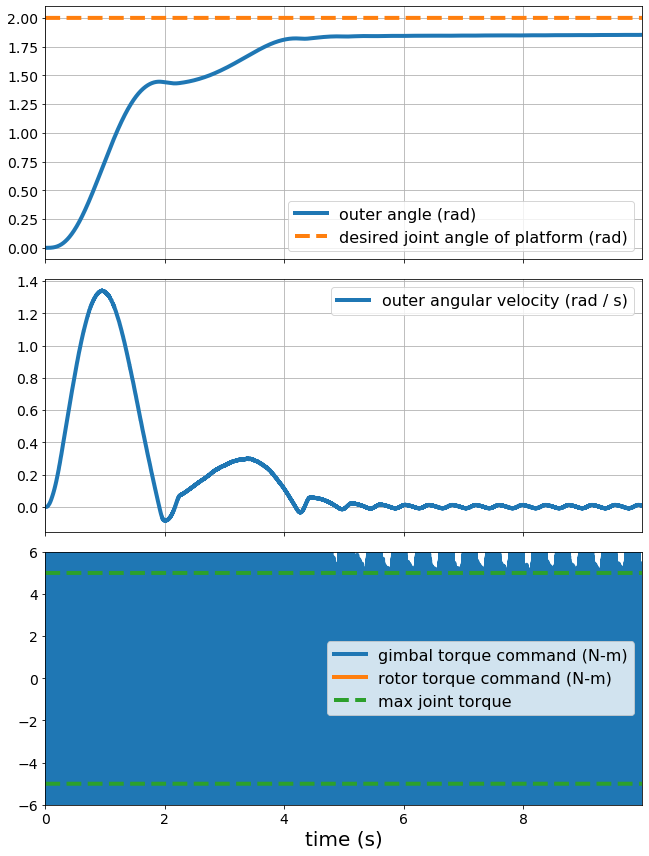

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q_1'], label='outer angle (rad)', linewidth=4)
ax[0].plot(data['t'], np.ones_like(data['t']) * controller.q1_e, '--', label='desired joint angle of platform (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v_1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau_2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau_3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[2].set_xlabel('time (s)', fontsize=20)
ax[2].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

# Results Summary1
It can be observed that our choice of gain matrix K indeed makes the CMG asymptotically stable, but there is a large error between the desired platform angle and the actual platform angle. The desired platform angle is 2.0 rad, but the actual platform angle converges to approximately 1.85 rad.

Now, we can try to implement a proportional-derivative controller without gain matrix K. It is known that a PD controller has the general form : `f = Kp(x_ref-x)+Kd(v_ref-v)`. Good news is this model is already linear. We only need to play with different values of Kp and Kd, which are simply scalars.


In [27]:
class RobotController:
    def __init__(self, dt=0.001):
        self.dt = dt
        self.q1_e = 2.0
        self.q2_e = 0.5
        self.v1_e = 0
        self.v2_e = 0
        self.v3_e = 0
        self.tau2_e = 0
        self.tau3_e=1
        
    #PD controller has the general form : f = Kp*(x_ref-x)+Kd*(v_ref-v)
    def run(self, q_1, v_1, q_2, v_2, q_3, v_3):
        tau_2 =  5.*(q_1 - q1_e) +2.5*(v_1 - 0.) - 5.*(q_2 - 0.) - 2.5*(v_2 - 0.)# torque on gimbal in Nm
        tau_3 = -5. #torque on rotor, in Nm
        

        
        return tau_2, tau_3

controller = RobotController(dt=robot.dt)

As suggested by the project guidelines, it's simpler to restrict our attention to the platform
and the gimbal, and treat the rotor as a soruce of torque.
PD controller: f = Kp(e(t))+Kp(e(t)')

In this expression, e(t) is the error value, and Kp is proportional gain,e(t)' is
time derivative of the error value

In [29]:
# Restore the simulation to its initial state
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q_1': np.empty(num_steps, dtype=float),
    'v_1': np.empty(num_steps, dtype=float),
    'q_2': np.empty(num_steps, dtype=float),
    'v_2': np.empty(num_steps, dtype=float),
    'q_3': np.empty(num_steps, dtype=float),
    'v_3': np.empty(num_steps, dtype=float),
    'tau_2': np.empty(num_steps, dtype=float),
    'tau_3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_1, v_1, q_2, v_2, q_3, v_3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_2, tau_3 = controller.run(q_1, v_1, q_2, v_2, q_3, v_3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q_1'][step] = q_1
    data['v_1'][step] = v_1
    data['q_2'][step] = q_2
    data['v_2'][step] = v_2
    data['q_3'][step] = q_3
    data['v_3'][step] = v_3
    data['tau_2'][step] = tau_2
    data['tau_3'][step] = tau_3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau_2, tau_3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

# Data visualization

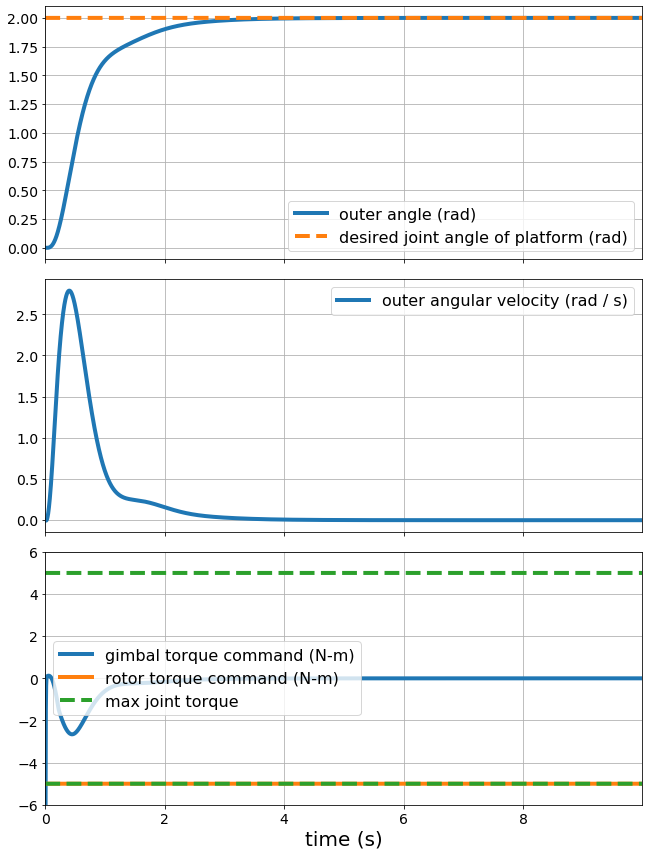

In [30]:
# Create a figure with three subplots, all of which share the same x-axis
fig, ax = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q_1'], label='outer angle (rad)', linewidth=4)
ax[0].plot(data['t'], np.ones_like(data['t']) * controller.q1_e, '--', label='desired joint angle of platform (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v_1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau_2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau_3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[2].set_xlabel('time (s)', fontsize=20)
ax[2].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

# Results Summary 2


The plots above indicate that my PD controller (linear-state feedback controller) accomplishes asymptotic stability at q1 = 2.0(rad), and as expected the angular velocity of the platform (v1) converges to 0 as the angle of the platform (q1) converges to 2.0(rad).

# Reflection on Project (project questions)

To investigate how the choie of goal angle affects the motion of our CMG, we can rerun the simulation with another `q1_des'

In [45]:
q1_e_new=1.5

In [46]:
class RobotController:
    def __init__(self, dt=0.001):
        self.dt = dt
        self.q1_e_new = 1.5 # New goal angle (rad)
        self.q2_e = 0.5
        self.v1_e = 0
        self.v2_e = 0
        self.v3_e = 0
        self.tau2_e = 0
        self.tau3_e=1
        
    #PD controller has the general form : f = Kp*(x_ref-x)+Kd*(v_ref-v)
    def run(self, q_1, v_1, q_2, v_2, q_3, v_3):
        tau_2 =  5.*(q_1 - q1_e_new) +2.5*(v_1 - 0.) - 5.*(q_2 - 0.) - 2.5*(v_2 - 0.)# torque on gimbal in Nm
        tau_3 = -5. #torque on rotor, in Nm
        

        
        return tau_2, tau_3

controller = RobotController(dt=robot.dt)

In [47]:
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q_1': np.empty(num_steps, dtype=float),
    'v_1': np.empty(num_steps, dtype=float),
    'q_2': np.empty(num_steps, dtype=float),
    'v_2': np.empty(num_steps, dtype=float),
    'q_3': np.empty(num_steps, dtype=float),
    'v_3': np.empty(num_steps, dtype=float),
    'tau_2': np.empty(num_steps, dtype=float),
    'tau_3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_1, v_1, q_2, v_2, q_3, v_3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_2, tau_3 = controller.run(q_1, v_1, q_2, v_2, q_3, v_3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q_1'][step] = q_1
    data['v_1'][step] = v_1
    data['q_2'][step] = q_2
    data['v_2'][step] = v_2
    data['q_3'][step] = q_3
    data['v_3'][step] = v_3
    data['tau_2'][step] = tau_2
    data['tau_3'][step] = tau_3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau_2, tau_3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

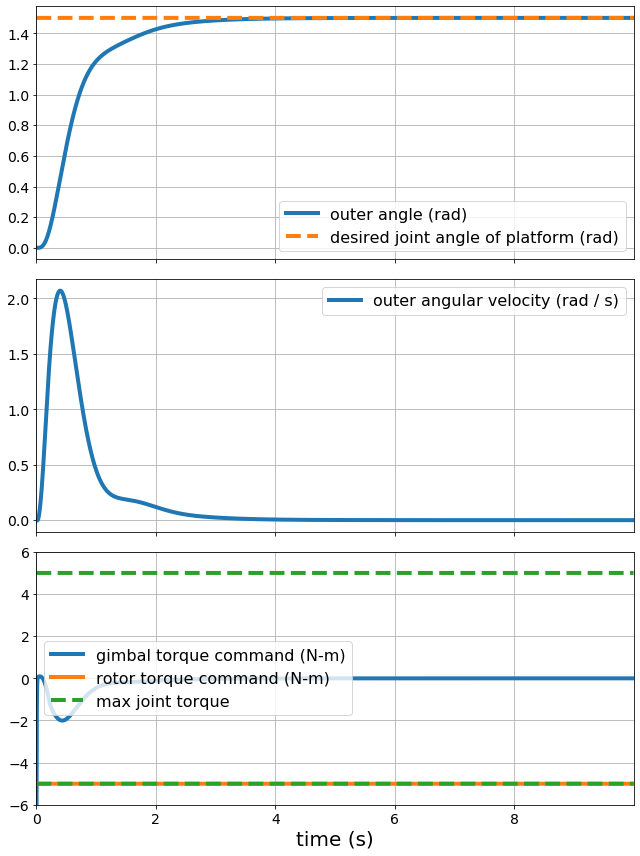

In [48]:
fig, ax = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q_1'], label='outer angle (rad)', linewidth=4)
ax[0].plot(data['t'], np.ones_like(data['t']) * controller.q1_e_new, '--', label='desired joint angle of platform (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14) 

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v_1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau_2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau_3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[2].set_xlabel('time (s)', fontsize=20)
ax[2].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Comparing the motion of our CMG when `q1_des`= 2.0 and 1.5 respectivley, we see that as the goal angle decreases, the maximum angular velocity acheived by the platform is smaller. When `q1_des` = 2.0, `v1_max` is approximately 2.7 rad/s. When `q1_des` = 1.5, `v1_max` is approximately 2.2. 

Next, we can change the rotor speed (v3) to check if our controller still works well.

In [31]:
class RobotController:
    def __init__(self, dt=0.001):
        self.dt = dt
        self.q1_e= 2.0 
        self.q2_e = 0.5
        self.v1_e = 0
        self.v2_e = 0
        self.v3_e = 1 # new motor speed
        self.tau2_e = 0
        self.tau3_e=1
        
    #PD controller has the general form : f = Kp*(x_ref-x)+Kd*(v_ref-v)
    def run(self, q_1, v_1, q_2, v_2, q_3, v_3):
        tau_2 =  5.*(q_1 - q1_e) +2.5*(v_1 - 0.) - 5.*(q_2 - 0.) - 2.5*(v_2 - 0.)# torque on gimbal in Nm
        tau_3 = -5. #torque on rotor, in Nm
        

        
        return tau_2, tau_3

controller = RobotController(dt=robot.dt)

In [32]:
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q_1': np.empty(num_steps, dtype=float),
    'v_1': np.empty(num_steps, dtype=float),
    'q_2': np.empty(num_steps, dtype=float),
    'v_2': np.empty(num_steps, dtype=float),
    'q_3': np.empty(num_steps, dtype=float),
    'v_3': np.empty(num_steps, dtype=float),
    'tau_2': np.empty(num_steps, dtype=float),
    'tau_3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_1, v_1, q_2, v_2, q_3, v_3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_2, tau_3 = controller.run(q_1, v_1, q_2, v_2, q_3, v_3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q_1'][step] = q_1
    data['v_1'][step] = v_1
    data['q_2'][step] = q_2
    data['v_2'][step] = v_2
    data['q_3'][step] = q_3
    data['v_3'][step] = v_3
    data['tau_2'][step] = tau_2
    data['tau_3'][step] = tau_3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau_2, tau_3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

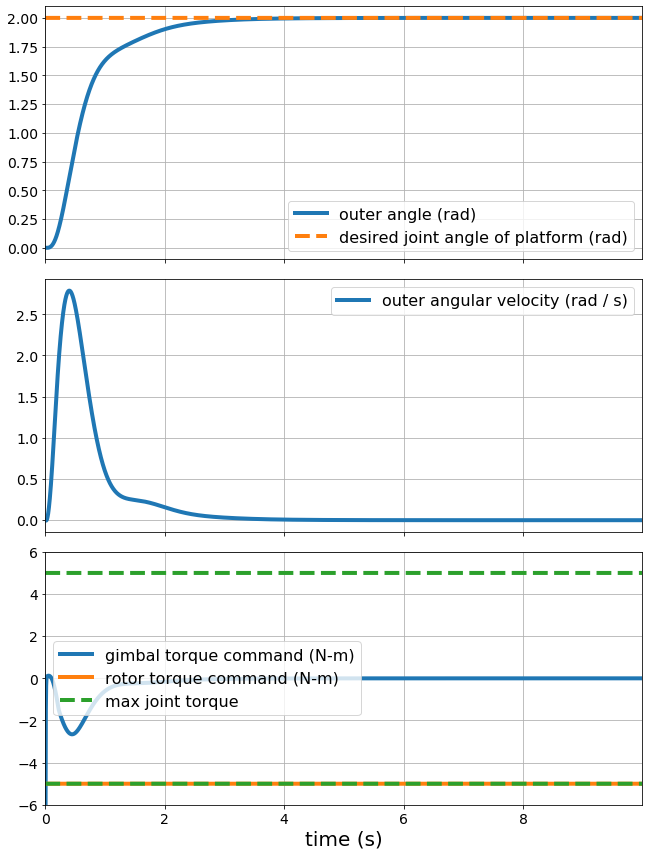

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q_1'], label='outer angle (rad)', linewidth=4)
ax[0].plot(data['t'], np.ones_like(data['t']) * controller.q1_e, '--', label='desired joint angle of platform (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14) 

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v_1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau_2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau_3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[2].set_xlabel('time (s)', fontsize=20)
ax[2].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

As we can observe, changing the rotor speed (v3) does not affect the motion of the CMG. Our controller still works well when `v3=1 rad/s` compared to `v3=0`

# Conclusion
See 01_report.pdf